In [11]:
import numpy as np
import tensorflow_probability as tfp
from utils import CORR, UNCORR, CORR_FT, UNCORR_FT

def get_local_periodic_kernel(
    periodic_length_scale, period, amplitude, local_length_scale
):
    """
    Composite kernel functions which is product of ExpSinSquared and Exponential Quadratic
    """
    periodic = tfp.math.psd_kernels.ExpSinSquared(
        amplitude=amplitude, length_scale=periodic_length_scale, period=period
    )
    local = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=local_length_scale)
    return periodic * local


def get_cov_mat(
    x, periodic_length_scale=1.0, period=1.0, amplitude=1.0, local_length_scale=1.0
):
    cov = (
        get_local_periodic_kernel(
            periodic_length_scale=periodic_length_scale,
            period=period,
            amplitude=amplitude,
            local_length_scale=local_length_scale,
        )
        .matrix(x, x)
        .numpy()
    )
    return cov

In [2]:
from matplotlib import pyplot as plt

In [7]:
def _get_avail_mat(
    mean_seq,
    cov,
    seq_len,
    n_clients,
    freq1,
):

    y = np.random.multivariate_normal(mean=mean_seq, cov=cov, size=n_clients)
    thresh = np.quantile(y, [1 - freq1], method="higher", axis=1).T
    y_bin = (y >= thresh).astype(np.int8)

    return y_bin

2024-10-24 11:26:00.356098: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 11:26:00.360704: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 11:26:00.371225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 11:26:00.389345: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 11:26:00.394758: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 11:26:00.410016: I tensorflow/core/platform/cpu_feature_gu

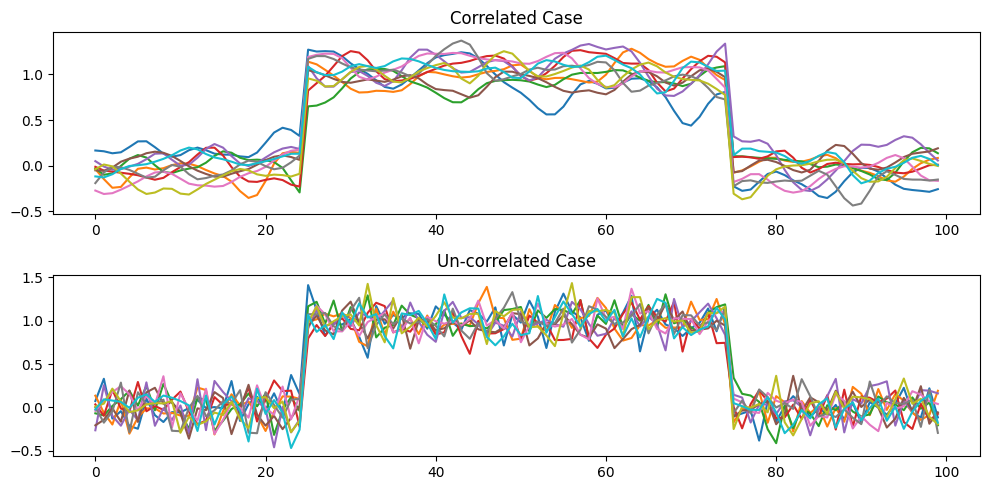

In [3]:
meafns = np.array([0 for _ in range(25)] + [1 for _ in range(50)] + [0 for _ in range(25)])
xlim = (-3, 3)
x = np.expand_dims(np.linspace(*xlim, 100), 1)
corr_cov = get_cov_mat(
        x=x,
        periodic_length_scale=1.0,
        period=1.0,
        amplitude=0.15,
        local_length_scale=1.0,
    )
uncorr_cov = get_cov_mat(
        x=x,
        periodic_length_scale=1.0,
        period=1.0,
        amplitude=0.15,
        local_length_scale=0.01,
    )

y_corr = np.random.multivariate_normal(mean=meafns, cov=corr_cov, size=10)
y_uncorr = np.random.multivariate_normal(mean=meafns, cov=uncorr_cov, size=10)

n_rows = 2
n_cols = 1

# Plot for y_corr
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5))
axes = axes.ravel()
for _ in range(10):
    axes[0].plot(y_corr[_,:])
axes[0].set_title("Correlated Case")

for _ in range(10):
    axes[1].plot(y_uncorr[_,:])
axes[1].set_title("Un-correlated Case")

plt.tight_layout()
plt.show()

In [8]:
import pandas as pd

In [9]:
countries = [i+1 for i in range(7)]

In [15]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from ipywidgets import interact, FloatSlider, VBox
import ipywidgets as widgets
import seaborn as sns

# Interactive function to plot correlated and uncorrelated cases
def plot_interactive(mean_amp, freq1, period, amplitude, local_length_scale_corr, local_length_scale_uncorr):
    meafns = np.array([0 for _ in range(25)] + [mean_amp for _ in range(50)] + [0 for _ in range(25)])
    xlim = (-3, 3)
    x = np.expand_dims(np.linspace(*xlim, 100), 1)

    # Generate correlated and uncorrelated covariance matrices
    corr_cov = get_cov_mat(
        x=x,
        periodic_length_scale=1.0,
        period=period,
        amplitude=amplitude,
        local_length_scale=local_length_scale_corr,
    )
    uncorr_cov = get_cov_mat(
        x=x,
        periodic_length_scale=1.0,
        period=period,
        amplitude=amplitude,
        local_length_scale=local_length_scale_uncorr,
    )

    # Generate samples from multivariate normal distribution
    y_corr = np.random.multivariate_normal(mean=meafns, cov=corr_cov, size=10)
    y_uncorr = np.random.multivariate_normal(mean=meafns, cov=uncorr_cov, size=10)
    
    
    avail_mat = {
        CORR: np.vstack(
            [
                _get_avail_mat(
                    mean_seq=meafns,
                    cov=corr_cov,
                    seq_len=100,
                    n_clients=1,
                    freq1=freq1,
                )
                for _ in range(7)
            ]
        ),
        UNCORR: np.vstack(
            [
                _get_avail_mat(
                    mean_seq=meafns,
                    cov=uncorr_cov,
                    seq_len=100,
                    n_clients=1,
                    freq1=freq1,
                )
                for _ in range(7)
            ]
        ),
        CORR_FT: np.hstack(
            (
                np.vstack(
                    [
                        _get_avail_mat(
                            mean_seq=meafns[:-10],
                            cov=corr_cov[:-10, :-10],
                            seq_len=100 - 10,
                            n_clients=1,
                            freq1=(freq1 * 100 - 10) / (100 - 10),
                        )
                        for _ in range(7)
                    ]
                ),
                np.ones((7, 10)),
            )
        ),
        UNCORR_FT: np.hstack(
            (
                np.vstack(
                    [
                        _get_avail_mat(
                            mean_seq=meafns[:-10],
                            cov=uncorr_cov[:-10, :-10],
                            seq_len=100 - 1-0,
                            n_clients=1,
                            freq1=(freq1 * 100 - 10) / (100 - 10),
                        )
                        for _ in range(7)
                    ]
                ),
                np.ones((7, 10)),
            )
        ),
    }

    n_rows = 4
    n_cols = 1

    # Plot correlated and uncorrelated cases
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5))
    axes = axes.ravel()
    axes[0].cla()
    axes[1].cla()
    axes[2].cla()
    axes[3].cla()

    for _ in range(10):
        axes[0].plot(y_corr[_,:])
    axes[0].set_title("Correlated Case")
    
    formatted_array = list(range(100))
    
    availability_matrix = pd.DataFrame(avail_mat[CORR], index = countries, columns = formatted_array)
    
    
    cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
    sns.heatmap(availability_matrix.astype(int), annot=False, fmt='d', cbar=False, cmap=cmap, linewidths=0.5, linecolor='white', ax=axes[1]) # create heatmap

    if not isinstance(availability_matrix.columns[0], np.int64):
        plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
    xticks = axes[1].get_xticks()
    xticks = xticks[::2]
    axes[1].set_xticks(xticks) # set new xticks
    axes[1].set_title("Corr avail mat")

    for _ in range(10):
        axes[2].plot(y_uncorr[_,:])
    axes[2].set_title("Un-correlated Case")
    
    availability_matrix = pd.DataFrame(avail_mat[UNCORR], index = countries, columns = formatted_array)
    
    
    cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
    sns.heatmap(availability_matrix.astype(int), annot=False, fmt='d', cbar=False, cmap=cmap, linewidths=0.5, linecolor='white', ax=axes[3]) # create heatmap

    if not isinstance(availability_matrix.columns[0], np.int64):
        plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
    xticks = axes[1].get_xticks()
    xticks = xticks[::2]
    axes[3].set_xticks(xticks) # set new xticks
    axes[3].set_title("UnCorr avail mat")

    plt.tight_layout()
    plt.show()

# Sliders for interactive controls
mean_amp_slider = FloatSlider(min=0.0, max=1.0, step=0.1, value=0.5, Description="Mean max_val")
freq_slider = FloatSlider(min=0.2, max=1.0, step=0.1, value=0.4, Description="Freq")
period_slider = FloatSlider(min=0.1, max=1.0, step=0.1, value=1.0, description='Period')
amplitude_slider = FloatSlider(min=0.01, max=1.0, step=0.01, value=0.15, description='Amplitude')
local_length_scale_corr_slider = FloatSlider(min=0.01, max=2.0, step=0.01, value=1.0, description='Corr')
local_length_scale_uncorr_slider = FloatSlider(min=0.01, max=2.0, step=0.01, value=0.01, description='Uncorr')

# Interactive plot using ipywidgets
interact(
    plot_interactive,
    mean_amp = mean_amp_slider,
    freq1=freq_slider,
    period=period_slider,
    amplitude=amplitude_slider,
    local_length_scale_corr=local_length_scale_corr_slider,
    local_length_scale_uncorr=local_length_scale_uncorr_slider
)

interactive(children=(FloatSlider(value=0.5, description='mean_amp', max=1.0), FloatSlider(value=0.4, descript…

<function __main__.plot_interactive(mean_amp, freq1, period, amplitude, local_length_scale_corr, local_length_scale_uncorr)>

In [16]:

def get_cov_mat1(x, periodic_length_scale=1.0, period=1.0, amplitude=1.0):
    cov = (
        tfp.math.psd_kernels.ExpSinSquared(
            amplitude=amplitude, length_scale=periodic_length_scale, period=period
        )
        .matrix(x, x)
        .numpy()
    )
    return cov


def get_cov_mat2(
    x, local_length_scale=1.0
):
    cov = (
        tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=local_length_scale)
        .matrix(x, x)
        .numpy()
    )
    return cov

In [33]:
# Interactive function to plot correlated and uncorrelated cases
def plot_interactive1(mean_amp, freq1, period, amplitude):
    meafns = np.array([0 for _ in range(25)] + [mean_amp for _ in range(50)] + [0 for _ in range(25)])
    xlim = (-3, 3)
    x = np.expand_dims(np.linspace(*xlim, 100), 1)

    # Generate correlated and uncorrelated covariance matrices
    corr_cov = get_cov_mat1(
        x=x,
        periodic_length_scale=1.0,
        period=period,
        amplitude=amplitude,
    )

    # Generate samples from multivariate normal distribution
    y_corr = np.random.multivariate_normal(mean=meafns, cov=corr_cov, size=10)
    

    n_rows = 3
    n_cols = 1

    # Plot correlated and uncorrelated cases
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5))
    axes = axes.ravel()
    axes[0].cla()
    axes[1].cla()
    axes[2].cla()

    for _ in range(10):
        axes[0].plot(y_corr[_,:])
    axes[0].set_title("GP")
    
    formatted_array = list(range(100))
    
    availability_matrix = pd.DataFrame(np.vstack(
            [
                _get_avail_mat(
                    mean_seq=meafns,
                    cov=corr_cov,
                    seq_len=100,
                    n_clients=1,
                    freq1=freq1,
                )
                for _ in range(7)
            ]
        ), index = countries, columns = formatted_array)
    
    
    cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
    sns.heatmap(availability_matrix.astype(int), annot=False, fmt='d', cbar=False, cmap=cmap, linewidths=0.5, linecolor='white', ax=axes[1]) # create heatmap

    if not isinstance(availability_matrix.columns[0], np.int64):
        plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
    xticks = axes[1].get_xticks()
    xticks = xticks[::2]
    axes[1].set_xticks(xticks) # set new xticks
    axes[1].set_title("avail mat")
    
    axes[2].imshow(corr_cov, cmap='Greys')

    plt.tight_layout()
    plt.show()

# Sliders for interactive controls
mean_amp_slider1 = FloatSlider(min=0.0, max=1.0, step=0.1, value=0.5, Description="Mean max_val")
freq_slider1 = FloatSlider(min=0.2, max=1.0, step=0.1, value=0.4, Description="Freq")
period_slider1 = FloatSlider(min=0.6, max=2.0, step=0.02, value=0.8, description='Period')
amplitude_slider1 = FloatSlider(min=0.01, max=0.15, step=0.01, value=0.05, description='Amplitude')

# Interactive plot using ipywidgets
interact(
    plot_interactive1,
    mean_amp = mean_amp_slider1,
    freq1=freq_slider1,
    period=period_slider1,
    amplitude=amplitude_slider1
)

interactive(children=(FloatSlider(value=0.5, description='mean_amp', max=1.0), FloatSlider(value=0.4, descript…

<function __main__.plot_interactive1(mean_amp, freq1, period, amplitude)>

In [29]:
def plot_interactive2(mean_amp, freq1, local_length_scale):
    meafns = np.array([0 for _ in range(25)] + [mean_amp for _ in range(50)] + [0 for _ in range(25)])
    xlim = (-3, 3)
    x = np.expand_dims(np.linspace(*xlim, 100), 1)

    # Generate correlated and uncorrelated covariance matrices
    corr_cov = get_cov_mat2(
        x=x,
        local_length_scale=local_length_scale,
    )

    # Generate samples from multivariate normal distribution
    y_corr = np.random.multivariate_normal(mean=meafns, cov=corr_cov, size=10)
    

    n_rows = 3
    n_cols = 1

    # Plot correlated and uncorrelated cases
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5))
    axes = axes.ravel()
    axes[0].cla()
    axes[1].cla()
    axes[2].cla()

    for _ in range(10):
        axes[0].plot(y_corr[_,:])
    axes[0].set_title("GP")
    
    formatted_array = list(range(100))
    
    availability_matrix = pd.DataFrame(np.vstack(
            [
                _get_avail_mat(
                    mean_seq=meafns,
                    cov=corr_cov,
                    seq_len=100,
                    n_clients=1,
                    freq1=freq1,
                )
                for _ in range(7)
            ]
        ), index = countries, columns = formatted_array)
    
    
    cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
    sns.heatmap(availability_matrix.astype(int), annot=False, fmt='d', cbar=False, cmap=cmap, linewidths=0.5, linecolor='white', ax=axes[1]) # create heatmap

    if not isinstance(availability_matrix.columns[0], np.int64):
        plt.xticks(rotation=45, ha='right')  # rotate x-axis labels to diagonal
    xticks = axes[1].get_xticks()
    xticks = xticks[::2]
    axes[1].set_xticks(xticks) # set new xticks
    axes[1].set_title("avail mat")

    axes[2].imshow(corr_cov, cmap='Greys')
    
    plt.tight_layout()
    plt.show()

# Sliders for interactive controls
mean_amp_slider2 = FloatSlider(min=0.0, max=1.0, step=0.1, value=0.5, Description="Mean max_val")
freq_slider2 = FloatSlider(min=0.2, max=1.0, step=0.1, value=0.4, Description="Freq")
local_length_scale_corr_slider2 = FloatSlider(min=0.001, max=0.15, step=0.001, value=0.02, description='Length scale')

# Interactive plot using ipywidgets
interact(
    plot_interactive2,
    mean_amp = mean_amp_slider2,
    freq1=freq_slider2,
    local_length_scale=local_length_scale_corr_slider2
)

interactive(children=(FloatSlider(value=0.5, description='mean_amp', max=1.0), FloatSlider(value=0.4, descript…

<function __main__.plot_interactive2(mean_amp, freq1, local_length_scale)>